## Intro

The idea of this notebook was to figure out, how to use the potential of the cluster and parallelize the training of different ML models by using spark and hyperopt. Hyperopt is a general-purpose library, which can optimize any function that has parameters here is will use it to optimize loss functions like rmse, mape etc. 

First, I wanted to use an ARIMA model and optimize for p,d,q etc. but there are already dedicated solvers for that e.g AutoARIMA and so I decided to use the Prophet Model and optimize its hyperparameter. 

In addition to the hyperparameter of the model, I treated the sampling frequency as a hyperparameter as well. My idea was that maybe patterns are easier to fit on a weekly sampling than on daily or monthly and I would want hyperopt to figure that out and not dictate this beforehand. 

I understood that in the end the monthly predictions are what we want, so I evaluate all models always on the monthly predictions. 

I use sktime a popular ML time-series library which is does not include DL models.

Simon B, 05.06.2023

In [1]:
%pip install sktime==0.19.1 prophet==1.1.4 hyperopt==0.2.7

#the models like prophet are wrapped by sktime but sktime does not automatically install all models it has. 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sktime.forecasting.fbprophet import Prophet
from sktime.performance_metrics.forecasting import mean_squared_error

from hyperopt import fmin, hp, tpe
from hyperopt import SparkTrials, STATUS_OK

In [16]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
      #pdf.at[pdf.index[0],column]   = pdf[column].iloc[1] #this would assigne the value of the next day to the first day.

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
      #pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2] #this would assigne the value of the second last day to the last day.

  return pdf

In [17]:
url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
pdf = pd.read_csv(url,index_col=None)


# pdf = pd.read_csv("ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])
pdf = resample_fix_ends(pdf,"D")

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings
split = int(len(pdf)*0.8)

pdf

C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_21292\1935103253.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


,Value_NE5,Value_NE7
Timestamp,,
2015-01-01,2.146054e+06,4.563033e+06
2015-01-02,2.238787e+06,4.834561e+06
2015-01-03,2.226526e+06,4.923018e+06
2015-01-04,2.069093e+06,4.655374e+06
2015-01-05,2.792374e+06,5.792671e+06
...,...,...
2023-06-15,2.669253e+06,4.601819e+06
2023-06-16,2.597870e+06,4.575981e+06
2023-06-17,2.186101e+06,4.047845e+06


In [ ]:
def train_prophet(pdfTrain,pdfTest):
  """This function is just a wrapper for the hyperopt procedure."""


  def train(params):
    """
    This is our main training function which we pass to Hyperopt.
    It takes in hyperparameter settings, fits a model based on those settings,
    evaluates the model, and returns the loss. 
    """

    forecaster = Prophet(  
      add_country_holidays    = 'Switzerland',
      seasonality_mode        = 'additive',
      n_changepoints          = params['n_changepoints'],
      changepoint_prior_scale = params['changepoint_prior_scale'],
      holidays_prior_scale    = params['holidays_prior_scale'])

    forecaster.fit(pdfTrain)  
    y_pred = forecaster.predict(fh=pdfTest.index)

    rmse   = mean_squared_error(y_true=pdfTest, y_pred=y_pred, square_root=True)  

    return {'loss': rmse, 'status': STATUS_OK, 'Trained_Model': forecaster}
   
  # Next, define a search space for Hyperopt.
  search_space = {
    'n_changepoints'  : hp.uniform('n_changepoints', 0, 10),
    "changepoint_prior_scale": hp.loguniform("changepoint_prior_scale", -6.9, -0.69),
    "seasonality_prior_scale": hp.loguniform("seasonality_prior_scale", -6.9, 2.3),
    "holidays_prior_scale":    hp.loguniform("holidays_prior_scale", -6.9, 2.3),
  }

  # Select a search algorithm for Hyperopt to use.
  algo=tpe.suggest  # Tree of Parzen Estimators, a Bayesian method

  # Distribute tuning across our Spark cluster, could also put timeout=10*60 for 10min run. 
  spark_trials = SparkTrials(parallelism=4)

  best_hyperparameters = fmin(fn=train,space=search_space,algo=algo,trials=spark_trials,max_evals=2)
  best_model = spark_trials.results[np.argmin([r['loss'] for r in spark_trials.results])]['Trained_Model']

  print(best_hyperparameters)
  return best_model,best_hyperparameters

##Train 2 models for NE5 and NE7 separately

In [ ]:
#train two separate models
best_induvidual_models = {}
best_model_params = {}

colum_names = ["Value_NE5","Value_NE7"]

for colum in colum_names:
  
  induvidual_pdf = pdf.copy()

  colum_to_drop = [x for x in colum_names if x != colum]
  induvidual_pdf = induvidual_pdf.drop(columns=colum_to_drop) #drop the unwanted columns
  
  pdf_train, pdf_test = induvidual_pdf.iloc[:split], induvidual_pdf.iloc[split:]
  best_induvidual_models[colum],best_model_params[colum] = train_prophet(pdf_train,pdf_test)



100%|██████████| 100/100 [01:50<00:00,  1.10s/trial, best loss: 2979963.046444973]Total Trials: 100: 100 succeeded, 0 failed, 0 cancelled.

{'changepoint_prior_scale': 0.16974589647454702, 'holidays': 0, 'holidays_prior_scale': 0.39396667391114887, 'n_changepoints': 2, 'sampling_frequency': 1, 'seasonality_mode': 1}
100%|██████████| 100/100 [02:07<00:00,  1.28s/trial, best loss: 3044904.5310212597]
Total Trials: 100: 100 succeeded, 0 failed, 0 cancelled.
{'changepoint_prior_scale': 0.19626295814780917, 'holidays': 0, 'holidays_prior_scale': 0.26812459275991946, 'n_changepoints': 1, 'sampling_frequency': 1, 'seasonality_mode': 1}


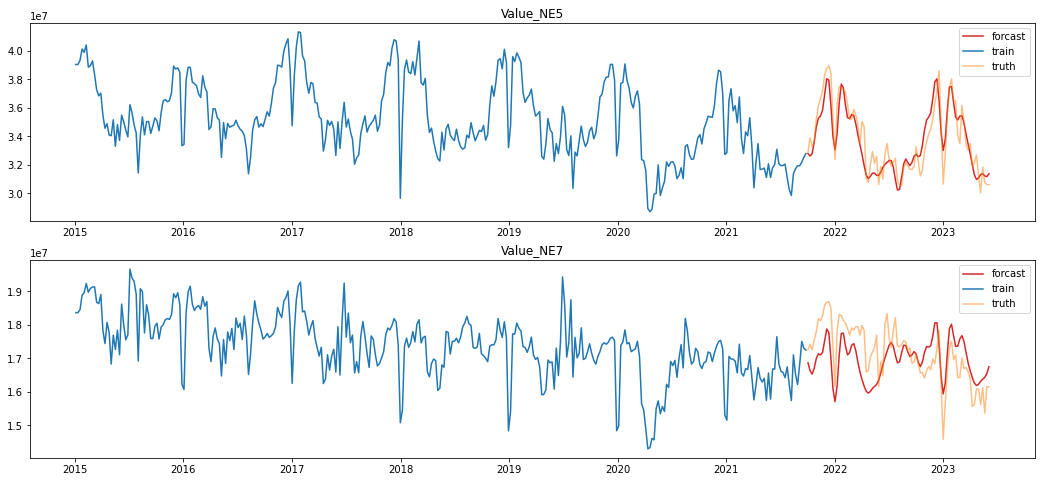

In [ ]:
#plot the outcome of two separate models

induvidual_predictions = []

f, axes = plt.subplots(2, 1,figsize=(18,8))


for i,colum in enumerate(colum_names):
  pdf1 = pdf.copy()
  colum_to_drop = [x for x in colum_names if x != colum]
  pdf1 = pdf1.drop(columns=colum_to_drop)

  best_induvidual = best_induvidual_models[colum]

  split = int(len(pdf1)*0.8)
  pdf1_train, pdf1_test = pdf1.iloc[:split], pdf1.iloc[split:]
  y_pred = best_induvidual.predict(pdf1_test.index)
  
  axes[i].plot(y_pred, color="tab:red", label="forcast")
  axes[i].plot(pdf1_train, color="tab:blue", label="train")
  axes[i].plot(pdf1_test, color="tab:orange", label="truth", alpha=0.5)

  axes[i].legend()
  axes[i].set_title(colum) #this label is wrong
  
  induvidual_predictions.append([y_pred,pdf1_train,pdf1_test])


plt.show()

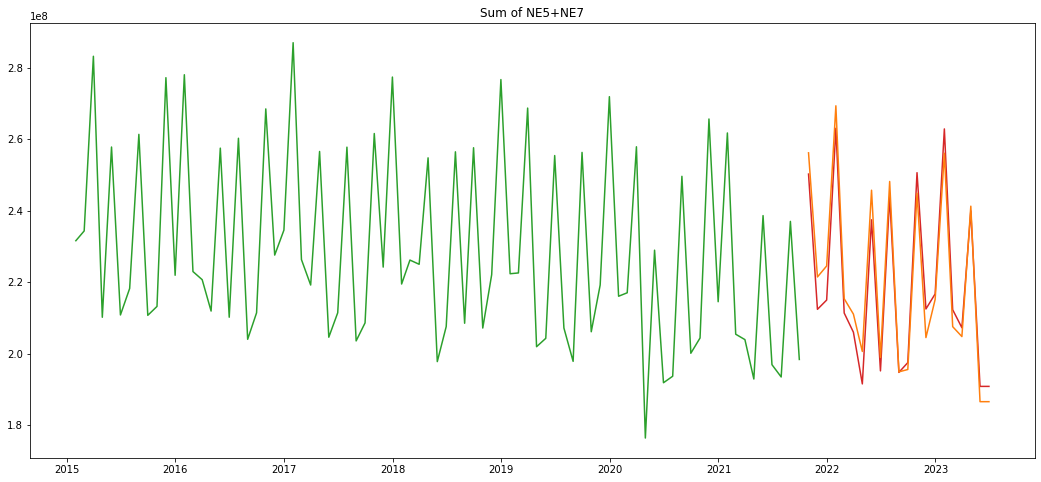

5732131.568693122


In [ ]:
#now resample the two series to monthly and then sum them. 

f, axes = plt.subplots(1, 1,figsize=(18,8))

y_pred    = resample_fix_ends(induvidual_predictions[1][0],"M")+resample_fix_ends(induvidual_predictions[0][0],"M").values
pdf_train = resample_fix_ends(induvidual_predictions[1][1],"M")+resample_fix_ends(induvidual_predictions[0][1],"M").values         
pdf_test  = resample_fix_ends(induvidual_predictions[1][2],"M")+resample_fix_ends(induvidual_predictions[0][2],"M").values         

plt.plot(y_pred, color="tab:red")
plt.plot(pdf_train, color="tab:green")
plt.plot(pdf_test, color="tab:orange")
plt.title("Sum of NE5+NE7")
plt.show()

#evaluate how good the model is--> rmse
rmse   = mean_squared_error(y_true=pdf_test, y_pred=y_pred, square_root=True) 
print(rmse)

## Train a single model on the sum

In [ ]:
#train singel model on the sum of the two columns

sum_pdf = pdf.copy()
sum_pdf["total"] = pdf["Value_NE5"].values + pdf["Value_NE7"].values
sum_pdf = sum_pdf.drop(columns=["Value_NE5","Value_NE7"])
split = int(len(sum_pdf)*0.8)

pdf_train, pdf_test = sum_pdf.iloc[:split], sum_pdf.iloc[split:]
best_model,best_hyperparameters = train_prophet(pdf_train,pdf_test)


100%|██████████| 100/100 [02:11<00:00,  1.31s/trial, best loss: 5741196.630257406]
Total Trials: 100: 100 succeeded, 0 failed, 0 cancelled.
{'changepoint_prior_scale': 0.17237661712833197, 'holidays': 0, 'holidays_prior_scale': 0.4547425583134249, 'n_changepoints': 0, 'sampling_frequency': 1, 'seasonality_mode': 1}


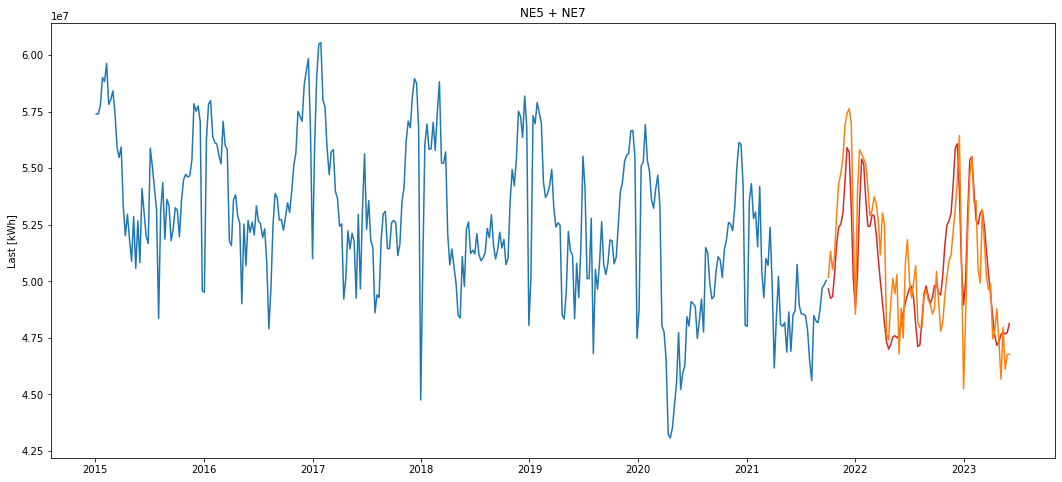

In [ ]:
#plot the outcome of the model on the summed data.

plt.figure(figsize=(18, 8))

sampling = tested_sampling[best_hyperparameters["sampling_frequency"]]

pdf2 = sum_pdf.copy()
pdf2 = resample_fix_ends(pdf2, sampling) 
split = int(len(pdf2)*0.8)
pdf2_train, pdf2_test = pdf2.iloc[:split], pdf2.iloc[split:]
y_pred = best_model.predict(pdf2_test.index)

plt.plot(y_pred, color="tab:red", label="forcast")
plt.plot(pdf2_train, color="tab:blue", label="train")
plt.plot(pdf2_test, color="tab:orange", label="truth")
plt.title("NE5 + NE7")
plt.ylabel("Last [kWh]")
plt.show()



#Plot monthly as well. 

## Notes

In [ ]:

# space = hp.choice('classifier_type', [
#     {
#         'type': 'naive_bayes',
#     },
#     {
#         'type': 'svm',
#         'C': hp.lognormal('svm_C', 0, 1),
#         'kernel': hp.choice('svm_kernel', [
#             {'ktype': 'linear'},
#             {'ktype': 'RBF', 'width': hp.lognormal('svm_rbf_width', 0, 1)},
#             ]),
#     },
#     {
#         'type': 'dtree',
#         'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
#         'max_depth': hp.choice('dtree_max_depth',
#             [None, hp.qlognormal('dtree_max_depth_int', 3, 1, 1)]),
#         'min_samples_split': hp.qlognormal('dtree_min_samples_split', 2, 1, 1),
#     },
#     ])